# Comparing logs against ground truth results

## Some questions:

### Size
- How many log entries are there?
- How many ground truth entries are there?
- How many bees are identified in the ground truth?
- How many bees are identified in the log?

### Relationship between log and ground truth
- Do multiple log entries map to the same ground truth entry?
- Do multiple ground truth entries map to the same log entry?

### True and False Positives (TP & FP)
- What is the True Positive (TP) and False Positive (FP) rates for logs?
- Which type of event does the log have the highest TP rate (it is best at finding these)?
- Which causes the most FPs?

## Helper Functions

In [496]:
%matplotlib inline
from utils import load_log, timestamp_to_seconds
from typing import Tuple, Dict
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def question_answer(question: str, answer: str) -> None:
    """Cleanly print a question and answer in 2 columns"""
    print(f"{question:40} {answer:40}")

def load_log_and_ground_truth(
        log_path: str, 
        ground_truth_path: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load the log and ground truth, and clean them up a bit."""

    # load the log
    log = load_log(log_path)
    

    # load the ground truth
    ground_truth = pd.read_csv(ground_truth_path)
    ground_truth.columns = [
        "GT Bee ID",
        "Start Timestamp",
        "End Timestamp",
        "Event Type",
        "Description"
    ]

    # clean the ground truth
    ground_truth["Start Timestamp"] = pd.to_datetime(ground_truth["Start Timestamp"].str.replace(".", ":", regex=False))
    ground_truth["End Timestamp"] = pd.to_datetime(ground_truth["End Timestamp"].str.replace(".", ":", regex=False))

    return (log, ground_truth)

def draw_tubes_with_ids(video_path:str, log_path: str, ground_truth_bee_id_img_path: str, radius: int=25) -> None:

    # get tube hive coordinates
    hive_coords = []
    with open(log_path, "r") as f:
        lines = f.readlines()
        hive_coord_lines = [line for line in lines if "Tube Hive Coords" in line]
        
        for line in hive_coord_lines:
            bee_id = int(line.split("=")[1].split(" ")[0])

            coords_clean = line.split(":")[1].strip().replace("  ", ",").replace(" ", ",")
            coords = eval(coords_clean)
            hive_coords.append({
                "bee_id": bee_id,
                "coords": coords
            })
    
    # load frame 31 of the video
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 31-1) # the motion cap tool waits till the 31st frame
    res, frame = cap.read()

    # draw the bee ids on the frame
    RED = (255, 0, 0)
    for hive_coord in hive_coords:
        cv2.circle(frame, hive_coord["coords"], radius, RED, 2)
        cv2.putText(frame, str(hive_coord["bee_id"]), (
            hive_coord["coords"][0] - 15,
            hive_coord["coords"][1] + 10
        ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, RED, 2)

    # load the ground truth bee id image
    ground_truth_bee_id_img = cv2.imread(ground_truth_bee_id_img_path)

    # place the two images side by side, with labels

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(frame)
    axs[0].set_title("Bee IDs identified by computer vision")
    axs[1].imshow(ground_truth_bee_id_img)
    axs[1].set_title("Ground Truth Bee IDs")

    # disable axis ticks
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    plt.show()


def DBSCAN_cluster_bee_events(events, eps=0.5, min_samples=2):
    """Cluster bee events using DBSCAN. Return the data, with any events in a cluste replaced with the cluster centroid."""

    events_copy = events.copy()
    
    X = events_copy["timestamp"].dt.strftime("%H:%M:%S").apply(timestamp_to_seconds)
    X = X.values.reshape(-1, 1)

    dbs = DBSCAN(eps=eps, min_samples=min_samples)
    predictions = dbs.fit_predict(X)

    events_copy["cluster"] = predictions

    # get cluster centroids
    cluster_centroids = events_copy.groupby("cluster").timestamp.mean().reset_index()
    cluster_centroids.columns = ["cluster", "timestamp"]

    # only keep events that aren't assigned to a cluster, and then add the centroids onto that
    events_copy = events_copy[events_copy.cluster == -1]
    events_copy = events_copy[["cluster", "timestamp"]]
    events_copy = events_copy.append(cluster_centroids)
    
    
    return events_copy
    

## Generating mapping between Bee IDs in CV and Ground Truth

First, we need to know which Bee IDs in the logs correspond to which Bee IDs in the ground truth. We can manually do this by looking at the identified Bee IDs by computer vision and the referenced image used by the human labeller side-by-side.

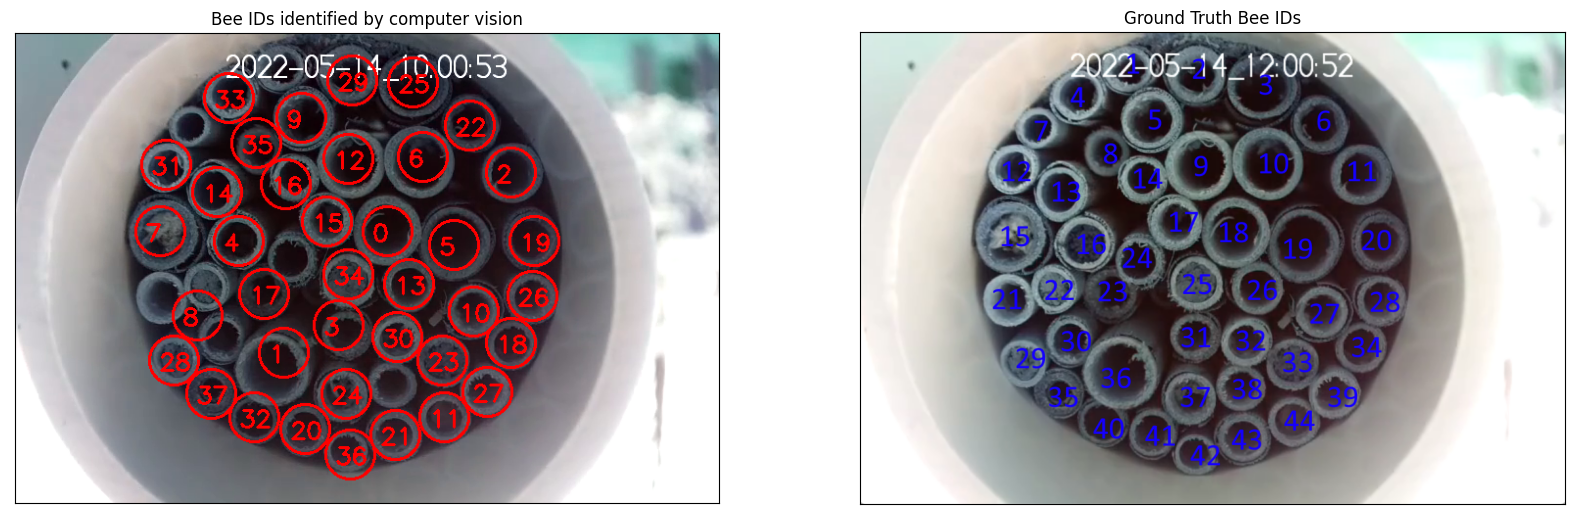

In [461]:
draw_tubes_with_ids(
    video_path=r"C:\Users\grego\OneDrive\Pictures\Documents\Projects\BeeHotel\2022-05-14_10_00.mp4", 
    log_path=r"C:\Users\grego\OneDrive\College\Research\Bee Hotel Research\logs\10am_log.txt",
    ground_truth_bee_id_img_path=r"C:\Users\grego\OneDrive\College\Research\Bee Hotel Research\figures\Bee IDs.png")

In [462]:
# Ground Truth to Computer Vision Bee ID Mapping
gt_to_cv_bee_id_mapping = {
    1: None,
    2: 29,
    3: 25,
    4: 33,
    5: 9,
    6: 22,
    7: None,
    8: 35,
    9: 12,
    10: 6,
    11: 2,
    12: 31,
    13: 14,
    14: 16,
    15: 7,
    16: 4,
    17: 15,
    18: 0,
    19: 5,
    20: 19,
    21: None,
    22: None,
    23: 17,
    24: None,
    25: 34,
    26: 13,
    27: 10,
    28: 26,
    29: 28,
    30: None,
    31: 3,
    32: 30,
    33: 23,
    34: 18,
    35: 37,
    36: 1, # this one is questionable
    37: 24,
    38: None,
    39: 27,
    40: 32,
    41: 20,
    42: 36,
    43: 21,
    44: 11
}

# For now, drop parts of the mapping with a key of none
gt_to_cv_bee_id_mapping = {k: v for k, v in gt_to_cv_bee_id_mapping.items() if v is not None}

# reverse the mapping for when we need it 
cv_to_gt_bee_id_mapping = {v: k for k, v in gt_to_cv_bee_id_mapping.items()}

print("Number of Bee IDs with a mapping between CV and GT:", len(gt_to_cv_bee_id_mapping))


Number of Bee IDs with a mapping between CV and GT: 37


In [463]:
gt_bee_id = 5
print(f"Bee ID={gt_bee_id} in the Ground Truth is Bee ID={gt_to_cv_bee_id_mapping[gt_bee_id]} in the Computer Vision logs")

Bee ID=5 in the Ground Truth is Bee ID=9 in the Computer Vision logs


## Load and process data

First let's load the data and, using our mappings, get a common "Ground Truth Bee ID" in both of the datasets. Since there are some tubes that were failed to be identified by the computer vision, we will only look at the tubes that were identified by the computer vision and compare them to the ground truth.

In [464]:
log, ground_truth = load_log_and_ground_truth(
    r"C:\Users\grego\OneDrive\College\Research\Bee Hotel Research\logs\10am_log.txt",
    r"C:\Users\grego\OneDrive\College\Research\Bee Hotel Research\data\Ground Truth Bee Events 2022-05-14 10am.csv"
)

# rename log bee_id to CV Bee ID for clarity
log = log.rename(columns={"bee_id": "CV Bee ID"})

gt_bee_ids_with_mapping = gt_to_cv_bee_id_mapping.keys()
cv_bee_ids_with_mapping = cv_to_gt_bee_id_mapping.keys()

# subset the ground truth to only include the bee ids with a mapping
ground_truth = ground_truth[ground_truth["GT Bee ID"].isin(gt_bee_ids_with_mapping)]

# subset the log to only include the bee ids with a mapping
log = log[log["CV Bee ID"].isin(cv_bee_ids_with_mapping)]

# apply the mappings
ground_truth["CV Bee ID"] = ground_truth["GT Bee ID"].apply(lambda gt_bee_id: gt_to_cv_bee_id_mapping[gt_bee_id])
log["GT Bee ID"] = log["CV Bee ID"].apply(lambda cv_bee_id: cv_to_gt_bee_id_mapping[cv_bee_id])

Now we will apply some clustering to remove noise in the data. This will average events that are very close to one another into one event. This simplifies events that were captured as multiple very close events, and gives us a better sense of True Positives and False Positives. If we don't do this, one incorrectly identified event can cause a lot of noise in the data.

In [465]:
# maximum number of seconds events can be apart to be considered part of the same cluster
DBSCAN_EPSILON = 10

# minimum number of events in a cluster
DBSCAN_MIN_SAMPLES = 3

print(f"DBSCAN Parameters: epsilon: {DBSCAN_EPSILON}, min_samples: {DBSCAN_MIN_SAMPLES}")

clustered = log.groupby("GT Bee ID").apply(lambda bee_events: DBSCAN_cluster_bee_events(bee_events, 
        eps=DBSCAN_EPSILON, 
        min_samples=DBSCAN_MIN_SAMPLES
        ))
clustered_events = clustered.reset_index().drop(["level_1"], axis=1)

# some analysis to give us an idea of what the clustering did
n_clusters = clustered_events[clustered_events.cluster != -1].cluster.nunique()
n_events_no_cluster = len(clustered_events[clustered_events.cluster == -1])
n_events_clustered = log.shape[0] - n_events_no_cluster
print("-- CLUSTERING INSIGHTS --")
print("Number of clusters:", n_clusters)
print("Number of events clustered:", n_events_clustered)
print("Number of events not clustered:", n_events_no_cluster)
print("-------------------------")
print(f"CV reduced from {log.shape[0]} events to {clustered_events.shape[0]} events")

DBSCAN Parameters: epsilon: 10, min_samples: 3
-- CLUSTERING INSIGHTS --
Number of clusters: 39
Number of events clustered: 2948
Number of events not clustered: 684
-------------------------
CV reduced from 3632 events to 1043 events


Some final cleaning to finalize or Computer Vision (CV) and Ground Truth (GT) datasets for analysis.

In [466]:
CV = clustered_events.copy()
GT = ground_truth.copy()

# drop day, month, and year
dmy = dict(day=1, month=1, year=2022)
CV["timestamp"] = CV["timestamp"].apply(lambda timestamp: timestamp.replace(**dmy))
GT["Start Timestamp"] = GT["Start Timestamp"].apply(lambda timestamp: timestamp.replace(**dmy))
GT["End Timestamp"] = GT["End Timestamp"].apply(lambda timestamp: timestamp.replace(**dmy))

In [467]:
CV.head()

,GT Bee ID,cluster,timestamp
0,2,-1,2022-01-01 10:13:35
1,2,-1,2022-01-01 10:13:35
2,2,-1,2022-01-01 10:36:37
3,2,-1,2022-01-01 10:36:37
4,2,-1,2022-01-01 10:52:08


In [468]:
GT.head()

,GT Bee ID,Start Timestamp,End Timestamp,Event Type,Description,CV Bee ID
0,16,2022-01-01 10:01:18,2022-01-01 10:01:31,work (fussing around inside),NaN,4
1,16,2022-01-01 10:01:31,NaT,exit,NaN,4
2,27,2022-01-01 10:02:30,NaT,enter head first,NaN,10
3,13,2022-01-01 10:02:50,2022-01-01 10:02:50,enter head first,NaN,14
4,27,2022-01-01 10:03:18,2022-01-01 10:03:21,turn around,NaN,10


## Visualize Computer Vision (CV) vs ground truth (GT) events

Let's visualize the CV and GT events for each bee, along with the True Positives, False Positives, and precision per bee.

First, we need to find the number of true positives, false positives, and precision for each bee id

In [546]:
# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

def TP_FP_precision(CV, GT) -> Tuple[int, int, float, pd.DataFrame]:
    """Calculate the True Positives, False Positives, and precision given Computer Vision and Ground Truth data. Also return the labelled data (TP or FP for each CV event)."""

    # preserve CV index for later
    CV["CV index"] = CV.index

    # when End Timestamp is NaT, set to Start Timestamp
    GT["End Timestamp"] = GT["End Timestamp"].fillna(GT["Start Timestamp"])

    # combine CV and GT data on GT Bee ID
    joined_on_gt_id = pd.merge(CV, GT, on="GT Bee ID", how="inner")

    # find where CV timestamp is within a `buffer`` amount of seconds of GT start or end timestamp
    BUFFER = 3
    TPs = joined_on_gt_id[
        (joined_on_gt_id["timestamp"] >= joined_on_gt_id["Start Timestamp"] - pd.Timedelta(seconds=BUFFER))
        & (joined_on_gt_id["timestamp"] <= joined_on_gt_id["End Timestamp"] + pd.Timedelta(seconds=BUFFER))
    ]
    FPs = CV[CV["CV index"].isin(TPs["CV index"]) == False]

    TP = TPs.shape[0]
    FP = FPs.shape[0]
    try:
        precision = round(TP/(TP + FP), 2) * 100
    except ZeroDivisionError:
        precision = -1
    
    # generate labelled data
    TPs["label"] = "TP"
    FPs["label"] = "FP"
    labelled = TPs.append(FPs)
    labelled = labelled[["GT Bee ID", "timestamp", "label"]]

    return TP, FP, precision, labelled

tp_fp_precision_df = []
labelled_cv = pd.DataFrame()
for gt_bee_id in gt_bee_ids_with_mapping:
    GT_subset = GT[GT["GT Bee ID"] == gt_bee_id]
    CV_subset = CV[CV["GT Bee ID"] == gt_bee_id]
    tp, fp, precision, labelled = TP_FP_precision(CV_subset, GT_subset)
    if precision == -1:
        pass
    tp_fp_precision_df.extend([
        {
            "stat": "TP",
            "value": tp,
            "GT Bee ID": gt_bee_id,
        }, 
        {
            "stat": "FP",
            "value": fp,
            "GT Bee ID": gt_bee_id,
        },
        {
            "stat": "precision",
            "value": precision,
            "GT Bee ID": gt_bee_id,
        }
        ])
    labelled_cv = labelled_cv.append(labelled)
tp_fp_precision_df = pd.DataFrame(tp_fp_precision_df)
labelled_cv = pd.DataFrame(labelled_cv)
tp_fp_precision_df.head()

,stat,value,GT Bee ID
0,TP,0.0,2
1,FP,15.0,2
2,precision,0.0,2
3,TP,0.0,3
4,FP,27.0,3


In [547]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# generate pairs for line segments from ground truth events that have an end timestamp
gt_segments = GT[GT["End Timestamp"].notna()]
gt_pairs = list(zip(gt_segments["Start Timestamp"], gt_segments["End Timestamp"]))
x = []
y = []
for pair, bee_id in zip(gt_pairs, GT["GT Bee ID"]):
    x.append(pair[0])
    x.append(pair[1])
    x.append(None)

    y.append(bee_id)
    y.append(bee_id)
    y.append(None)

fig = make_subplots(rows=1, cols=2, shared_yaxes=True, column_widths=[0.8, 0.2], horizontal_spacing=0.05)

# add gt lines
gt_lines = go.Scatter(
            x=x, 
            y=y, 
            mode="lines", 
            name="Ground Truth (with duration)", 
            line=dict(color="black", width=5)
)
gt_lines.hovertemplate = "%{x} GT Bee ID: %{y}"
fig.add_trace(gt_lines, row=1, col=1)


# add gt points without an end timestamp to the figure
gt_points = GT[GT["End Timestamp"].isna()]
gt_scatter = go.Scatter(
            x=gt_points["Start Timestamp"], 
            y=gt_points["GT Bee ID"], 
            mode="markers", 
            name="Ground Truth", 
            marker=dict(color="black", size=7, symbol="diamond")
)
gt_scatter.hovertemplate = "%{x} GT Bee ID: %{y}"
fig.add_trace(gt_scatter, row=1, col=1)

# add log points
colors = {
    "TP": "green",
    "FP": "red",
}
for label_type in ["TP", "FP"]:
    labelled = labelled_cv[labelled_cv["label"] == label_type]
    cv_scatter = go.Scatter(
            x=labelled["timestamp"], 
            y=labelled["GT Bee ID"], 
            mode="markers", 
            name="Computer Vision", 
            marker=dict(color=colors[label_type], size=5, line=dict(width=0.5, color='DarkSlateGrey')))
    cv_scatter.hovertemplate = "%{x} GT Bee ID: %{y}"
    fig.add_trace(cv_scatter,row=1, col=1)

# add TP, FP, and precision bar chart on side
colors = {
    "TP": "green",
    "FP": "red",
    "precision": "orange"
}
for stat_type in ["TP", "FP", "precision"]:
    bar = go.Bar(
            x=tp_fp_precision_df[tp_fp_precision_df["stat"] == stat_type]["value"], 
            y=tp_fp_precision_df[tp_fp_precision_df["stat"] == stat_type]["GT Bee ID"], 
            name=stat_type, 
            orientation="h", 
            marker_color=colors[stat_type]
        )

    # format bar's hover text
    bar.hovertemplate = stat_type + ": " + "%{x} Bee ID=%{y}"

    fig.add_trace(bar, row=1, col=2)

# set fig layout
fig.update_layout(
    title="Ground Truth vs Computer Vision Events",
    xaxis_title="Time",
    yaxis_title="Ground Truth Bee ID",
    legend_title="Legend",
    font=dict(
        size=13,
    ),
    width=1700,
    height=1500,
)
# format date of x axis
fig.update_xaxes(
    tickformat="%H:%M:%S"
)

# plot using pyo
pyo.plot(fig, filename="ground_truth_vs_computer_vision_events.html")

'ground_truth_vs_computer_vision_events.html'

## Answering our questions

In [513]:
question_answer("Number of CV entries", CV.shape[0])
question_answer("Number of GT entries", GT.shape[0])
question_answer("Number of Bee IDs in CV", CV["GT Bee ID"].nunique())
question_answer("Number of Bee IDs in GT", GT["GT Bee ID"].nunique())

print("\n*There are based only on the tubes that the computer vision was able to find, and thus assign a Bee ID to.*")

Number of CV entries                                                         1043
Number of GT entries                                                          173
Number of Bee IDs in CV                                                        36
Number of Bee IDs in GT                                                        17

*There are based only on the tubes that the computer vision was able to find, and thus assign a Bee ID to.*


which GT Bee ID has the most TPs? FPs? Precision?

In [541]:
print("The Top 5 GT Bee IDs with the most True Positives are:")
tp_fp_precision_df[tp_fp_precision_df.stat == "TP"].sort_values(by="value", ascending=False).head(5)

The Top 5 GT Bee IDs with the most True Positives are:


,stat,value,GT Bee ID
39,TP,31.0,16
30,TP,30.0,13
15,TP,18.0,8
48,TP,14.0,19
54,TP,13.0,23


In [540]:
print("The Top 5 GT Bee IDs with the most False Positives are:")
tp_fp_precision_df[tp_fp_precision_df.stat == "FP"].sort_values(by="value", ascending=False).head(5)

The Top 5 GT Bee IDs with the most False Positives are:


,stat,value,GT Bee ID
28,FP,79.0,12
25,FP,72.0,11
88,FP,62.0,36
7,FP,50.0,4
37,FP,46.0,15


In [538]:
print("The Top 5 GT Bee IDs with the highest precision are:")
tp_fp_precision_df[tp_fp_precision_df.stat == "precision"].sort_values(by="value", ascending=False).head(5)

The Top 5 GT Bee IDs with the highest precision are:


,stat,value,GT Bee ID
17,precision,82.0,8
41,precision,60.0,16
32,precision,49.0,13
86,precision,46.0,35
65,precision,41.0,27


In [544]:
print("How much variation is there in the precision of the GT Bee IDs?")
precision_stats = tp_fp_precision_df[tp_fp_precision_df.stat == "precision"].value.describe()
question_answer("Mean", precision_stats["mean"])
question_answer("Standard Deviation", precision_stats["std"])
question_answer("Minimum", precision_stats["min"])
question_answer("Maximum", precision_stats["max"])

How much variation is there in the precision of the GT Bee IDs?
Mean                                                            14.81081081081081
Standard Deviation                                             21.096126339841312
Minimum                                                                      -1.0
Maximum                                                                      82.0
